In [1]:
import os
import shutil
import numpy as np
from tqdm import tqdm

# Path to your full image dataset with NORMAL and PNEUMONIA folders
original_data_dir = "chest_xray_full"

# Output directory for the split
output_dir = "chest_xray_split"
splits = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Ensure output subfolders exist
for split in splits:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Process each class separately for balanced splitting
for label in ['NORMAL', 'PNEUMONIA']:
    source_dir = os.path.join(original_data_dir, label)
    images = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    np.random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * splits['train'])
    n_val = int(n_total * splits['val'])
    n_test = n_total - n_train - n_val

    split_lists = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }

    for split, split_imgs in split_lists.items():
        dest_dir = os.path.join(output_dir, split, label)
        for fname in tqdm(split_imgs, desc=f"Copying {label} to {split}", leave=False):
            src_path = os.path.join(source_dir, fname)
            dst_path = os.path.join(dest_dir, fname)
            shutil.copy2(src_path, dst_path)

print("Splitting complete. New folders created under", output_dir)


Splitting complete. New folders created under chest_xray_split


Extracting PNEUMONIA: 100%|██████████| 2991/2991 [06:08<00:00,  8.12it/s]


Saved train features to train_handcrafted_features.csv


Extracting PNEUMONIA: 100%|██████████| 640/640 [01:22<00:00,  7.74it/s]


Saved val features to val_handcrafted_features.csv


Extracting PNEUMONIA: 100%|██████████| 642/642 [00:27<00:00, 23.47it/s]


Saved test features to test_handcrafted_features.csv


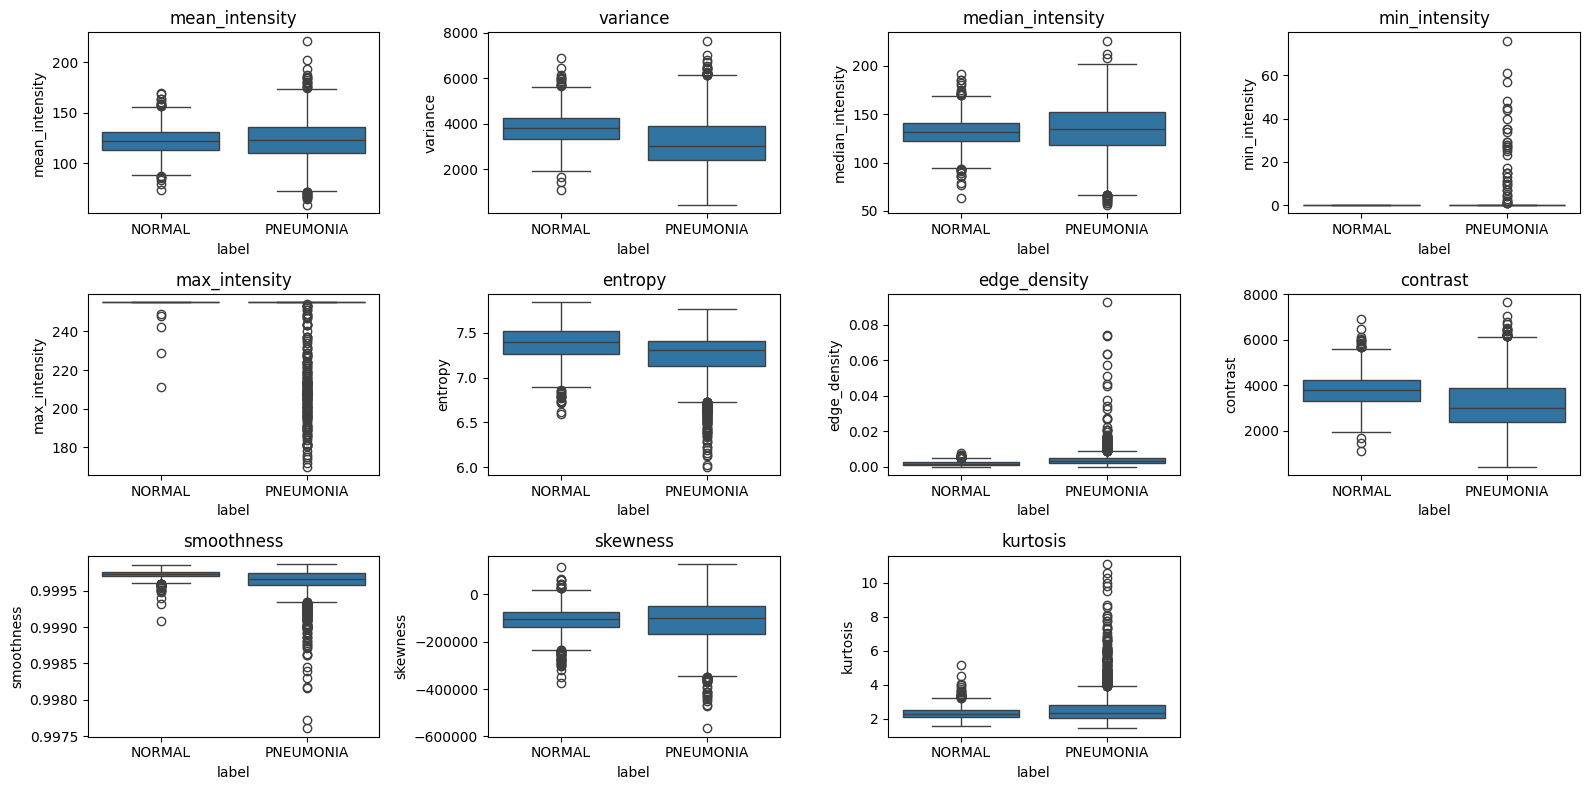

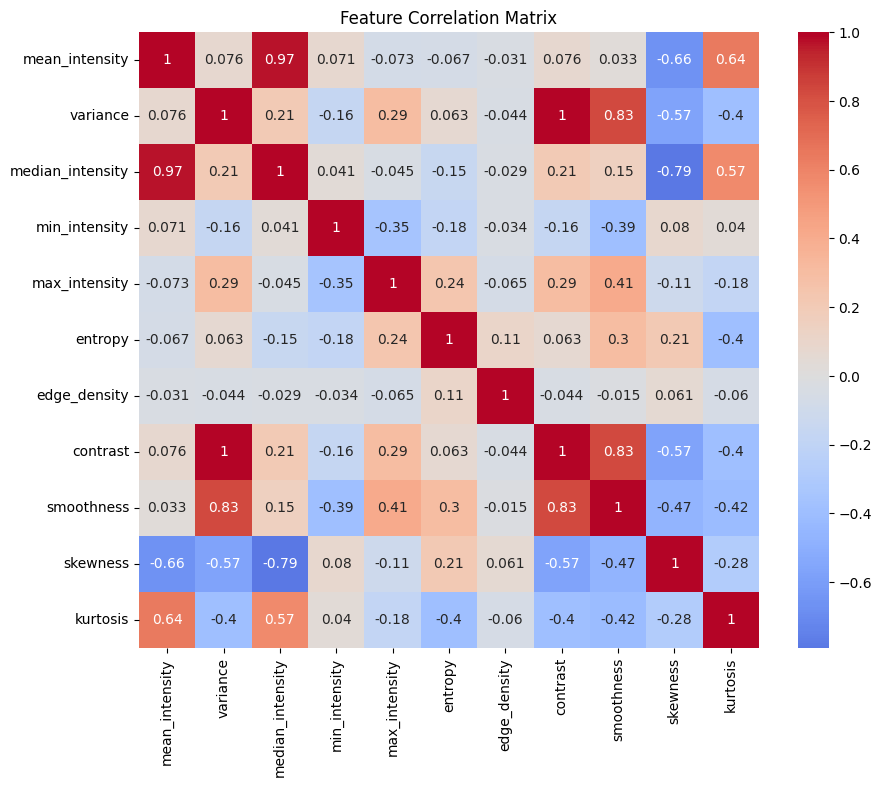

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Invalid image")
    mean_intensity = np.mean(img)
    variance = np.var(img)
    median = np.median(img)
    min_intensity = np.min(img)
    max_intensity = np.max(img)
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    hist_norm = hist / np.sum(hist)
    entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-7))
    edges = cv2.Canny(img, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    contrast = variance
    smoothness = 1 - (1 / (1 + variance))
    mean = mean_intensity
    skewness = np.mean((img - mean)**3)
    kurtosis = np.mean((img - mean)**4) / (variance**2 + 1e-7)
    return [
        mean_intensity, variance, median, min_intensity, max_intensity,
        entropy, edge_density, contrast, smoothness, skewness, kurtosis
    ]

def extract_features_from_dir(dir_path):
    rows = []
    for label in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in tqdm(os.listdir(class_dir), desc=f"Extracting {label}"):
            img_path = os.path.join(class_dir, img_name)
            try:
                feats = extract_features(img_path)
                rows.append([img_path, label] + feats)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    columns = [
        'image_path', 'label',
        'mean_intensity', 'variance', 'median_intensity', 'min_intensity', 'max_intensity',
        'entropy', 'edge_density', 'contrast', 'smoothness', 'skewness', 'kurtosis'
    ]
    return pd.DataFrame(rows, columns=columns)

# Run for each split
split_dirs = {
    "train": "chest_xray_split/train",
    "val": "chest_xray_split/val",
    "test": "chest_xray_split/test"
}
for split, dir_path in split_dirs.items():
    df = extract_features_from_dir(dir_path)
    df.to_csv(f"{split}_handcrafted_features.csv", index=False)
    print(f"Saved {split} features to {split}_handcrafted_features.csv")

# Visualization: Feature Distribution and Correlation (for train set)
df = pd.read_csv("train_handcrafted_features.csv")
features = [
    'mean_intensity', 'variance', 'median_intensity', 'min_intensity', 'max_intensity',
    'entropy', 'edge_density', 'contrast', 'smoothness', 'skewness', 'kurtosis'
]

# Boxplots for each feature
plt.figure(figsize=(16,8))
for i, feat in enumerate(features):
    plt.subplot(3,4,i+1)
    sns.boxplot(x='label', y=feat, data=df)
    plt.title(feat)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()


In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import transforms

class ImageFeatureDataset(Dataset):
    def __init__(self, csv_file, transform=None, feature_columns=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.feature_columns = feature_columns if feature_columns else []
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        features = self.data.iloc[idx][self.feature_columns].values.astype(np.float32)
        features = torch.tensor(features)
        label_str = self.data.iloc[idx]['label']
        label = 1 if label_str == 'PNEUMONIA' else 0
        return image, features, label


In [4]:
import torch.nn as nn
import timm

class HybridModel(nn.Module):
    def __init__(self, model_name, feature_dim, num_classes=2):
        super(HybridModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        backbone_output_dim = self.backbone.num_features
        self.feature_fc = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(backbone_output_dim + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x, features):
        x_feat = self.backbone(x)
        feat_embed = self.feature_fc(features)
        combined = torch.cat([x_feat, feat_embed], dim=1)
        out = self.classifier(combined)
        return out


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training swin_tiny_patch4_window7_224 model...


swin_tiny_patch4_window7_224 Epoch 1/8 -> Train Loss: 457.8943, Train Acc: 0.6180, Val Loss: 164.5825, Val Acc: 0.7286
Saved new best model for swin_tiny_patch4_window7_224 at epoch 1 with val acc 0.7286


swin_tiny_patch4_window7_224 Epoch 2/8 -> Train Loss: 253.6261, Train Acc: 0.6536, Val Loss: 43.8145, Val Acc: 0.7389
Saved new best model for swin_tiny_patch4_window7_224 at epoch 2 with val acc 0.7389


swin_tiny_patch4_window7_224 Epoch 3/8 -> Train Loss: 174.9598, Train Acc: 0.6665, Val Loss: 26.1801, Val Acc: 0.7423
Saved new best model for swin_tiny_patch4_window7_224 at epoch 3 with val acc 0.7423


swin_tiny_patch4_window7_224 Epoch 4/8 -> Train Loss: 107.7702, Train Acc: 0.6904, Val Loss: 6.4716, Val Acc: 0.8290
Saved new best model for swin_tiny_patch4_window7_224 at epoch 4 with val acc 0.8290


swin_tiny_patch4_window7_224 Epoch 5/8 -> Train Loss: 77.6294, Train Acc: 0.7007, Val Loss: 2.2115, Val Acc: 0.9111
Saved new best model for swin_tiny_patch4_window7_224 at epoch 5 with val acc 0.9111


swin_tiny_patch4_window7_224 Epoch 6/8 -> Train Loss: 56.3639, Train Acc: 0.7060, Val Loss: 5.0235, Val Acc: 0.7526


swin_tiny_patch4_window7_224 Epoch 7/8 -> Train Loss: 39.8583, Train Acc: 0.7097, Val Loss: 2.2856, Val Acc: 0.7845


swin_tiny_patch4_window7_224 Epoch 8/8 -> Train Loss: 30.3582, Train Acc: 0.7119, Val Loss: 0.8378, Val Acc: 0.9293
Saved new best model for swin_tiny_patch4_window7_224 at epoch 8 with val acc 0.9293


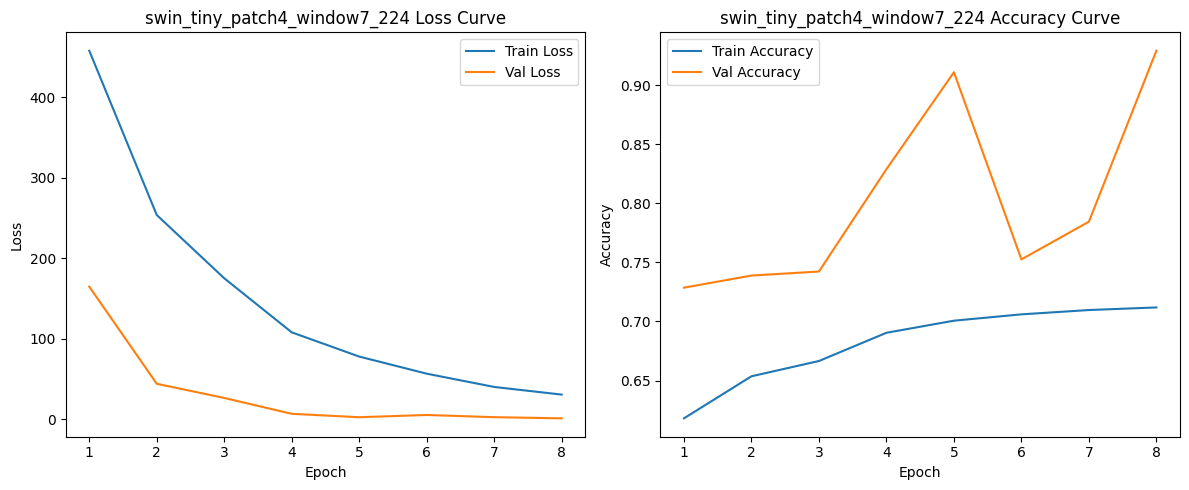


Training vit_base_patch16_224 model...


vit_base_patch16_224 Epoch 1/8 -> Train Loss: 467.0130, Train Acc: 0.6089, Val Loss: 61.7886, Val Acc: 0.7286
Saved new best model for vit_base_patch16_224 at epoch 1 with val acc 0.7286


vit_base_patch16_224 Epoch 2/8 -> Train Loss: 279.6928, Train Acc: 0.5960, Val Loss: 47.5642, Val Acc: 0.7092


vit_base_patch16_224 Epoch 3/8 -> Train Loss: 176.9343, Train Acc: 0.5960, Val Loss: 16.6107, Val Acc: 0.7206


vit_base_patch16_224 Epoch 4/8 -> Train Loss: 108.7679, Train Acc: 0.6153, Val Loss: 5.9806, Val Acc: 0.7275


vit_base_patch16_224 Epoch 5/8 -> Train Loss: 66.0887, Train Acc: 0.6121, Val Loss: 5.9321, Val Acc: 0.7229


vit_base_patch16_224 Epoch 6/8 -> Train Loss: 46.6252, Train Acc: 0.6133, Val Loss: 2.4063, Val Acc: 0.7263


vit_base_patch16_224 Epoch 7/8 -> Train Loss: 30.7748, Train Acc: 0.6067, Val Loss: 3.1703, Val Acc: 0.7298
Saved new best model for vit_base_patch16_224 at epoch 7 with val acc 0.7298


vit_base_patch16_224 Epoch 8/8 -> Train Loss: 19.8106, Train Acc: 0.6189, Val Loss: 2.0568, Val Acc: 0.3364


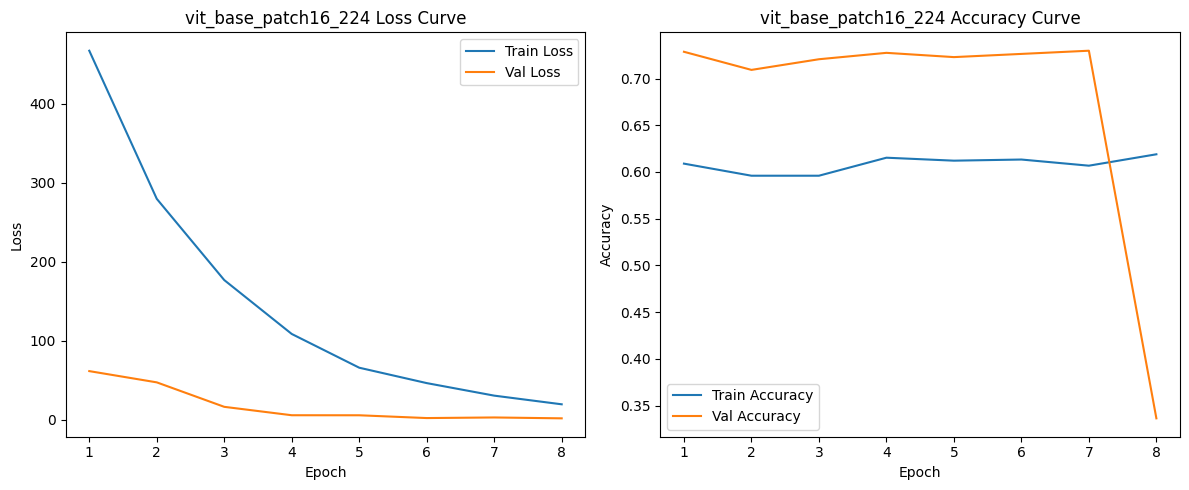


Training efficientnet_b0 model...


efficientnet_b0 Epoch 1/8 -> Train Loss: 415.6418, Train Acc: 0.6138, Val Loss: 44.9920, Val Acc: 0.7651
Saved new best model for efficientnet_b0 at epoch 1 with val acc 0.7651


efficientnet_b0 Epoch 2/8 -> Train Loss: 215.3781, Train Acc: 0.6406, Val Loss: 8.1554, Val Acc: 0.8974
Saved new best model for efficientnet_b0 at epoch 2 with val acc 0.8974


efficientnet_b0 Epoch 3/8 -> Train Loss: 121.3039, Train Acc: 0.6516, Val Loss: 3.2435, Val Acc: 0.8734


efficientnet_b0 Epoch 4/8 -> Train Loss: 71.7840, Train Acc: 0.6748, Val Loss: 1.7297, Val Acc: 0.8472


efficientnet_b0 Epoch 5/8 -> Train Loss: 49.1117, Train Acc: 0.6575, Val Loss: 4.2454, Val Acc: 0.7628


efficientnet_b0 Epoch 6/8 -> Train Loss: 33.2517, Train Acc: 0.6624, Val Loss: 1.4932, Val Acc: 0.8540


efficientnet_b0 Epoch 7/8 -> Train Loss: 19.6854, Train Acc: 0.6628, Val Loss: 1.3516, Val Acc: 0.8940


efficientnet_b0 Epoch 8/8 -> Train Loss: 12.8173, Train Acc: 0.6750, Val Loss: 1.3502, Val Acc: 0.8369


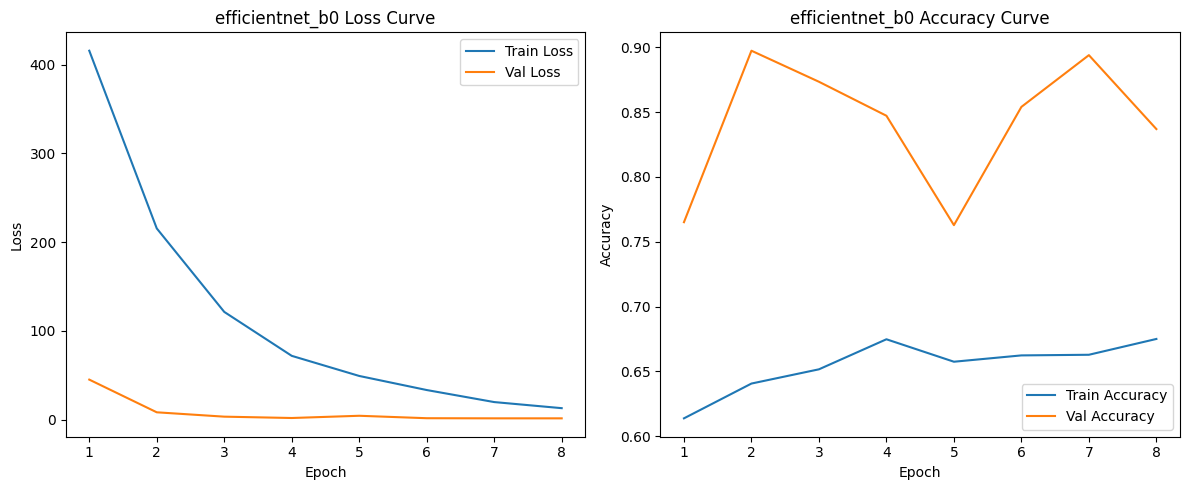

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 8
lr = 1e-4
batch_size = 32
feature_columns = [
    'mean_intensity', 'variance', 'median_intensity', 'min_intensity', 'max_intensity',
    'entropy', 'edge_density', 'contrast', 'smoothness', 'skewness', 'kurtosis'
]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
train_dataset = ImageFeatureDataset('train_handcrafted_features.csv', transform=transform, feature_columns=feature_columns)
val_dataset = ImageFeatureDataset('val_handcrafted_features.csv', transform=transform, feature_columns=feature_columns)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model_names = ['swin_tiny_patch4_window7_224', 'vit_base_patch16_224', 'efficientnet_b0']
models = {}
for name in model_names:
    models[name] = HybridModel(name, feature_dim=len(feature_columns)).to(device)
criterion = nn.CrossEntropyLoss()
optimizers = {name: optim.Adam(models[name].parameters(), lr=lr) for name in model_names}
history = {name: {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []} for name in model_names}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    optimizer = optimizers[model_name]
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_loop = tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}/{epochs} (Train)", leave=False)
        for images, features, labels in train_loop:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            train_loop.set_postfix(loss=loss.item())
        train_loss /= train_total
        train_acc = train_correct / train_total
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"{model_name} Epoch {epoch+1}/{epochs} (Val)", leave=False)
            for images, features, labels in val_loop:
                images, features, labels = images.to(device), features.to(device), labels.to(device)
                outputs = model(images, features)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_loop.set_postfix(val_loss=loss.item())
        val_loss /= val_total
        val_acc = val_correct / val_total
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['val_loss'].append(val_loss)
        history[model_name]['train_acc'].append(train_acc)
        history[model_name]['val_acc'].append(val_acc)
        print(f"{model_name} Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"Saved new best model for {model_name} at epoch {epoch+1} with val acc {val_acc:.4f}")
    df = pd.DataFrame({
        'epoch': list(range(1, epochs+1)),
        'train_loss': history[model_name]['train_loss'],
        'val_loss': history[model_name]['val_loss'],
        'train_acc': history[model_name]['train_acc'],
        'val_acc': history[model_name]['val_acc']
    })
    df.to_csv(f"{model_name}_metrics.csv", index=False)
    epochs_range = range(1, epochs+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history[model_name]['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history[model_name]['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range, history[model_name]['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history[model_name]['val_acc'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_35564\2146091717.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{name}_best.pth"))


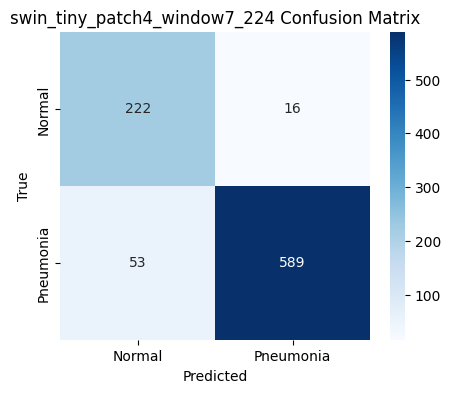

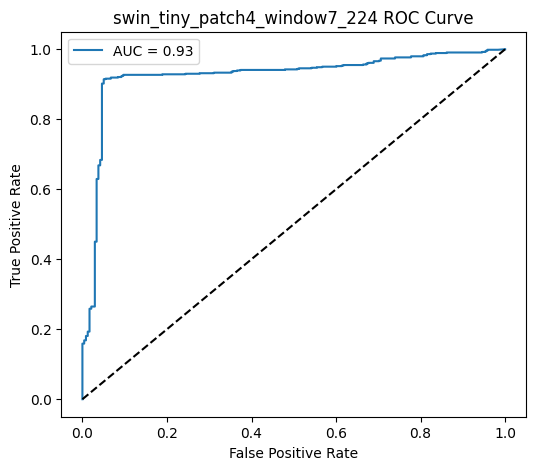

Classification Report for swin_tiny_patch4_window7_224:
              precision    recall  f1-score   support

      Normal       0.81      0.93      0.87       238
   Pneumonia       0.97      0.92      0.94       642

    accuracy                           0.92       880
   macro avg       0.89      0.93      0.91       880
weighted avg       0.93      0.92      0.92       880



C:\Users\ASUS\AppData\Local\Temp\ipykernel_35564\2146091717.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{name}_best.pth"))


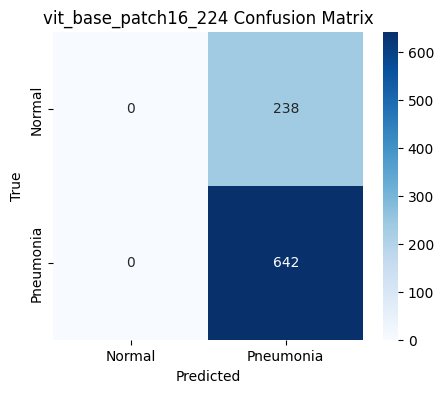

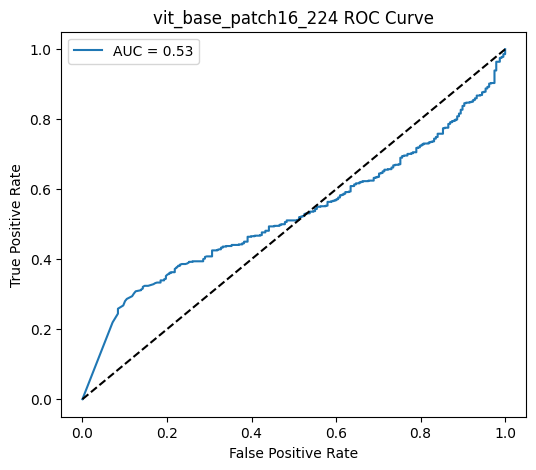

Classification Report for vit_base_patch16_224:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       238
   Pneumonia       0.73      1.00      0.84       642

    accuracy                           0.73       880
   macro avg       0.36      0.50      0.42       880
weighted avg       0.53      0.73      0.62       880



C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

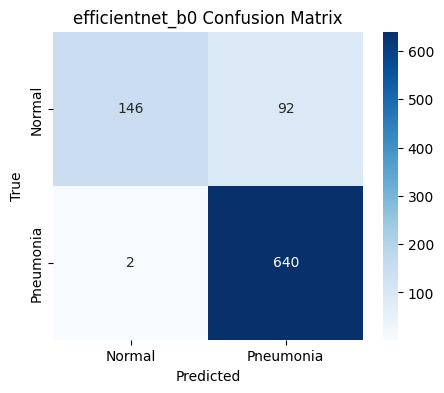

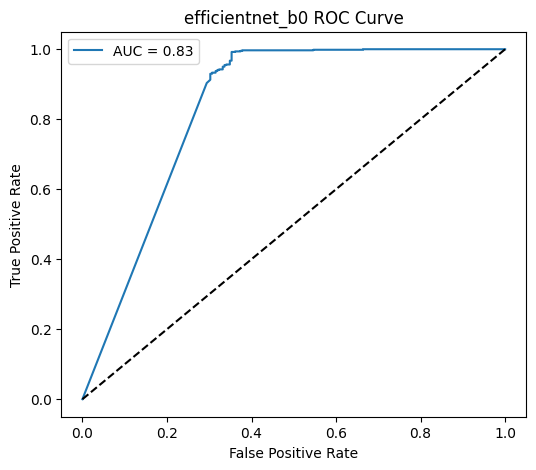

Classification Report for efficientnet_b0:
              precision    recall  f1-score   support

      Normal       0.99      0.61      0.76       238
   Pneumonia       0.87      1.00      0.93       642

    accuracy                           0.89       880
   macro avg       0.93      0.81      0.84       880
weighted avg       0.90      0.89      0.88       880



In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_dataset = ImageFeatureDataset('test_handcrafted_features.csv', transform=transform, feature_columns=feature_columns)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_names = ['swin_tiny_patch4_window7_224', 'vit_base_patch16_224', 'efficientnet_b0']
results = {}

for name in model_names:
    model = HybridModel(name, feature_dim=len(feature_columns)).to(device)
    model.load_state_dict(torch.load(f"{name}_best.pth"))
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, features, labels in test_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = model(images, features)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
    all_preds = [1 if p > 0.5 else 0 for p in all_probs]
    results[name] = {'labels': all_labels, 'probs': all_probs, 'preds': all_preds}

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:")
    print(classification_report(all_labels, all_preds, target_names=['Normal','Pneumonia']))


In [25]:
import torch.nn as nn

class ImageOnlyModel(nn.Module):
    def __init__(self, hybrid_model, features_tensor):
        super().__init__()
        self.hybrid_model = hybrid_model
        self.features_tensor = features_tensor
    def forward(self, x):
        batch_size = x.shape[0]
        features = self.features_tensor.repeat(batch_size, 1)
        return self.hybrid_model(x, features)



In [26]:
def reshape_transform(tensor):
    print(">>> reshape_transform input shape:", tensor.shape)
    # Case 1: [B, N, C] (ViT-style)
    if len(tensor.shape) == 3:
        if tensor.shape[1] > 1:
            tensor = tensor[:, 1:, :]
        batch, num_patches, hidden_dim = tensor.shape
        h = w = int(num_patches ** 0.5)
        if h * w != num_patches:
            print(f"WARNING: not a square patch grid, using fallback (flattened shape {num_patches})")
            raise ValueError(f"Unrecognized non-square patch count: {num_patches}")
        out = tensor.reshape(batch, h, w, hidden_dim).permute(0, 3, 1, 2)
        print("Returning shape [B, C, H, W]:", out.shape)
        return out
    # Case 2: [B, H, W, C] (Swin/block-style)
    elif len(tensor.shape) == 4:
        out = tensor.permute(0, 3, 1, 2)
        print("Returning shape [B, C, H, W]:", out.shape)
        return out
    # Unknown shape:
    raise ValueError(f"Unknown shape in reshape_transform: {tensor.shape}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_35564\2592231584.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hybrid_model.load_state_dict(torch.load(f"{name}_best.pth"))

>>> reshape_transform input shape: torch.Size([1, 7, 7, 768])
Returning shape [B, C, H, W]: torch.Size([1, 768, 7, 7])
>>> reshape_transform input shape: torch.Size([1, 7, 7, 768])
Returning shape [B, C, H, W]: torch.Size([1, 768, 7, 7])
>>> reshape_transform input shape: torch.Size([1, 197, 768])
Returning shape [B, C, H, W]: torch.Size([1, 768, 14, 14])
>>> reshape_transform input shape: torch.Size([1, 197, 768])
Returning shape [B, C, H, W]: torch.Size([1, 768, 14, 14])


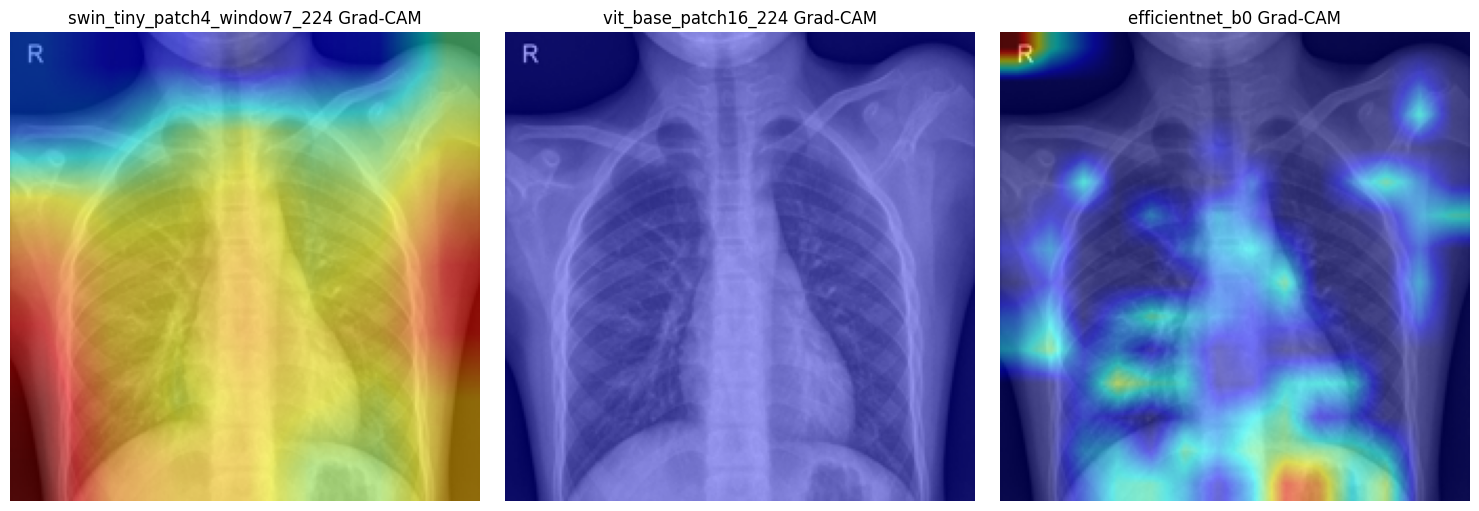

In [31]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

sample_idx = 0  # Pick a test image
img_path = test_dataset.data.iloc[sample_idx]['image_path']
raw_img = Image.open(img_path).convert('RGB')
input_tensor = transform(raw_img).unsqueeze(0).to(device)
features_tensor = torch.tensor(test_dataset.data.iloc[sample_idx][feature_columns].values.astype(np.float32)).unsqueeze(0).to(device)
rgb_img = np.array(raw_img.resize((224,224))) / 255.0

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, name in enumerate(model_names):
    hybrid_model = HybridModel(name, feature_dim=len(feature_columns)).to(device)
    hybrid_model.load_state_dict(torch.load(f"{name}_best.pth"))
    hybrid_model.eval()
    model = ImageOnlyModel(hybrid_model, features_tensor)
    if "swin" in name:
        # Usually use last block's norm1 for Swin
        target_layers = [model.hybrid_model.backbone.layers[-1].blocks[-1].norm1]
        cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    elif "vit" in name:
        # Last transformer block norm for ViT
        # For ViT (Vision Transformer)
        # Try one block before the last
        target_layers = [model.hybrid_model.backbone.blocks[-2]]  # Second-to-last block
        cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    elif "efficientnet" in name:
        # Last conv block for EfficientNet
        # For EfficientNet B0
        # For EfficientNet B0
        target_layers = [model.hybrid_model.backbone.blocks[-3]]  # Third-to-last block
        cam = GradCAM(model=model, target_layers=target_layers)
    else:
        raise ValueError("Unknown model type in model_names")
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    axes[i].imshow(visualization)
    axes[i].set_title(f"{name} Grad-CAM")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


>>> reshape_transform input shape: torch.Size([1, 16, 112, 112])
Returning shape [B, C, H, W]: torch.Size([1, 112, 16, 112])
>>> reshape_transform input shape: torch.Size([1, 16, 112, 112])
Returning shape [B, C, H, W]: torch.Size([1, 112, 16, 112])
>>> reshape_transform input shape: torch.Size([1, 24, 56, 56])
Returning shape [B, C, H, W]: torch.Size([1, 56, 24, 56])
>>> reshape_transform input shape: torch.Size([1, 24, 56, 56])
Returning shape [B, C, H, W]: torch.Size([1, 56, 24, 56])
>>> reshape_transform input shape: torch.Size([1, 40, 28, 28])
Returning shape [B, C, H, W]: torch.Size([1, 28, 40, 28])
>>> reshape_transform input shape: torch.Size([1, 40, 28, 28])
Returning shape [B, C, H, W]: torch.Size([1, 28, 40, 28])
>>> reshape_transform input shape: torch.Size([1, 80, 14, 14])
Returning shape [B, C, H, W]: torch.Size([1, 14, 80, 14])
>>> reshape_transform input shape: torch.Size([1, 80, 14, 14])
Returning shape [B, C, H, W]: torch.Size([1, 14, 80, 14])
>>> reshape_transform in

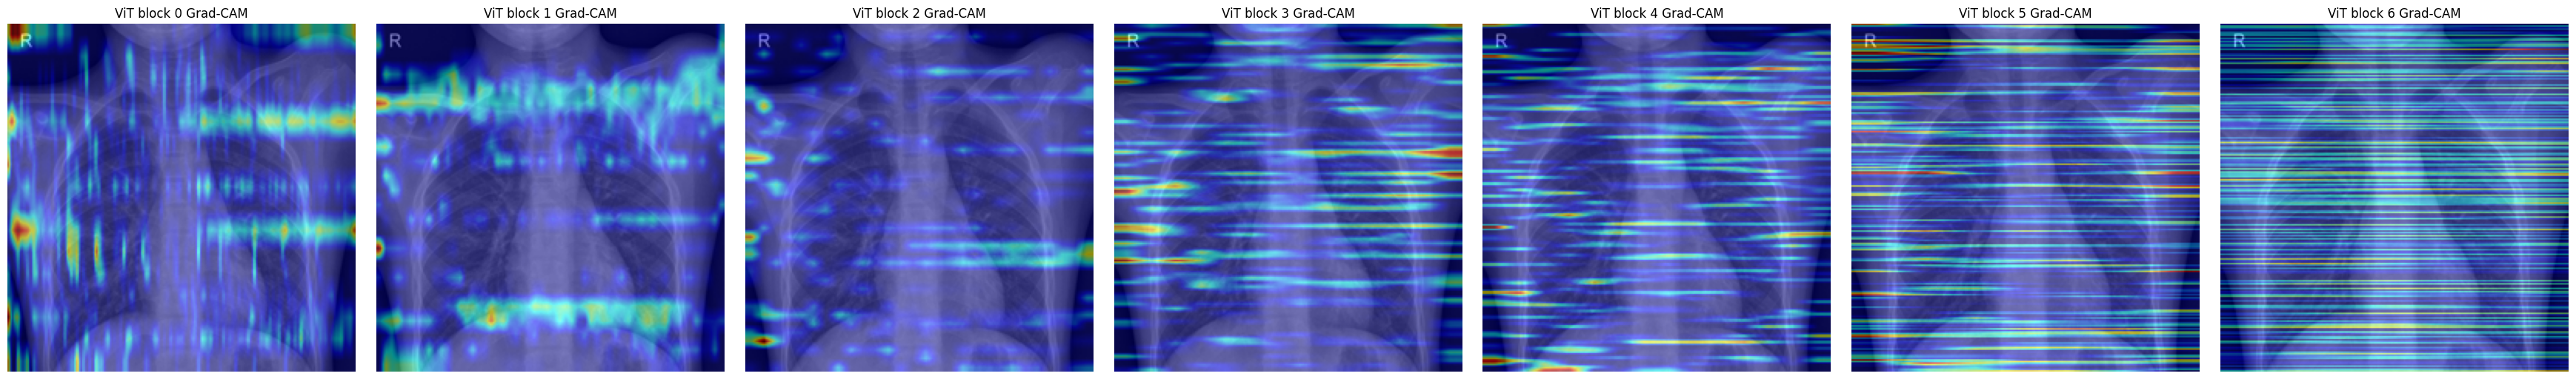

In [32]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

block_count = len(model.hybrid_model.backbone.blocks)

fig, axes = plt.subplots(1, block_count, figsize=(5*block_count, 5))
for n in range(block_count):
    target_layers = [model.hybrid_model.backbone.blocks[n]]  # n-th transformer block
    cam = GradCAM(
        model=model, 
        target_layers=target_layers, 
        reshape_transform=reshape_transform
    )
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    axes[n].imshow(visualization)
    axes[n].set_title(f"ViT block {n} Grad-CAM")
    axes[n].axis('off')
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_35564\620773722.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{name}_best.pth"))
Ensembl

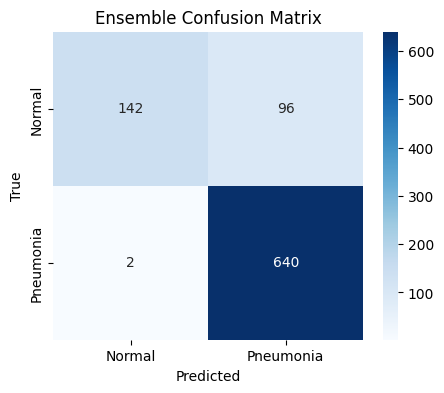

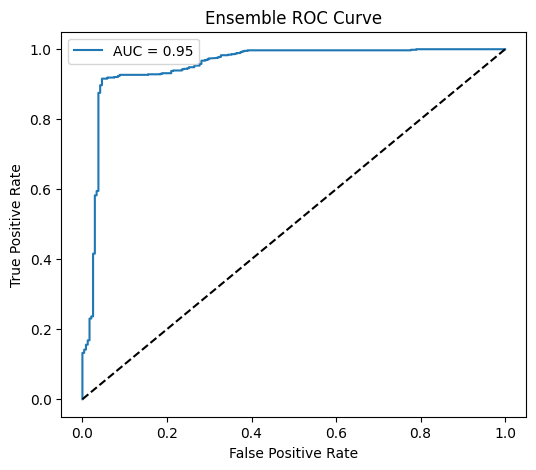

              precision    recall  f1-score   support

      Normal       0.99      0.60      0.74       238
   Pneumonia       0.87      1.00      0.93       642

    accuracy                           0.89       880
   macro avg       0.93      0.80      0.84       880
weighted avg       0.90      0.89      0.88       880



In [33]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load test dataset
test_dataset = ImageFeatureDataset('test_handcrafted_features.csv', transform=transform, feature_columns=feature_columns)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load models and weights
model_names = ['swin_tiny_patch4_window7_224', 'vit_base_patch16_224', 'efficientnet_b0']
models = {}
for name in model_names:
    model = HybridModel(name, feature_dim=len(feature_columns)).to(device)
    model.load_state_dict(torch.load(f"{name}_best.pth"))
    model.eval()
    models[name] = model

all_labels = []
all_probs = []

with torch.no_grad():
    for images, features, labels in tqdm(test_loader, desc="Ensemble Test Evaluation"):
        images, features = images.to(device), features.to(device)
        batch_probs = []
        for model in models.values():
            outputs = model(images, features)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # pneumonia class prob (assuming class 1=pneumonia)
            batch_probs.append(probs.cpu().numpy())
        avg_probs = np.mean(batch_probs, axis=0)
        all_probs.extend(avg_probs)
        all_labels.extend(labels.numpy())

# Convert probabilities to binary predictions with threshold 0.5
all_preds = [1 if p > 0.5 else 0 for p in all_probs]

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve')
plt.legend()
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))


In [22]:
import torch
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from timm import create_model
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(checkpoint_path, model_name):
    model = create_model(model_name, pretrained=False)
    # Load checkpoint on CPU first to reduce GPU memory peak
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('backbone.'):
            new_key = k[len('backbone.'):]
        else:
            new_key = k
        new_state_dict[new_key] = v

    model.load_state_dict(new_state_dict, strict=False)

    model.to(device)  # move model to GPU after loading
    model.eval()
    return model

class TabularLimeModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.original_model = original_model
        self.device = next(original_model.parameters()).device

    def forward(self, tabular_input_numpy):
        batch_size = tabular_input_numpy.shape[0]
        # Create dummy image batch on CPU then move to GPU
        dummy_images = torch.zeros((batch_size, 3, 224, 224), dtype=torch.float32).to(self.device)
        tabular_tensor = torch.tensor(tabular_input_numpy, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            outputs = self.original_model(dummy_images, tabular_tensor)

        return outputs.cpu().numpy()

# Load models
models = {
    'swin': load_model(r'C:\data_science\Pneumonia Prediction\swin_tiny_patch4_window7_224_best.pth', 'swin_tiny_patch4_window7_224'),
    'vit': load_model(r'C:\data_science\Pneumonia Prediction\vit_base_patch16_224_best.pth', 'vit_base_patch16_224'),
    'efficientnet': load_model(r'C:\data_science\Pneumonia Prediction\efficientnet_b0_best.pth', 'efficientnet_b0'),
}

feature_columns = [
    "mean_intensity", "variance", "median_intensity", "min_intensity",
    "max_intensity", "entropy", "edge_density", "contrast",
    "smoothness", "skewness", "kurtosis"
]

df_test = pd.read_csv('test_handcrafted_features.csv')
X_tabular = df_test[feature_columns].values.astype(np.float32)

for name, model in models.items():
    print(f"\nLIME explanation for model: {name}")
    lime_model = TabularLimeModel(model)

    explainer = LimeTabularExplainer(
        training_data=X_tabular,
        feature_names=feature_columns,
        mode='regression'  # Or 'classification' depending on your model
    )

    i = 0  # Explanation for first instance
    explanation = explainer.explain_instance(
        data_row=X_tabular[i],
        predict_fn=lime_model.forward,
        num_features=len(feature_columns),
        num_samples=500  # Adjust as needed for speed/memory
    )

    print(explanation.as_list())
    fig = explanation.as_pyplot_figure()
    fig.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11220\1902300555.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
